In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import *

N_SAMPLES = 10000
NUM_CLASSES = 10
NUM_FEATURES = 10
RANDOM_SEED = 42

print(f"Torch: version {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
!nvidia-smi

Torch: version 2.7.1
zsh:1: command not found: nvidia-smi


In [2]:
# Multiclass Classification

In [3]:
# Create the dataset
X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=.2,
                            random_state=RANDOM_SEED)

In [4]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [5]:
X_blob, y_blob

(tensor([[-9.5847,  9.9378,  6.7112,  ...,  0.4369, -1.1501, -4.2423],
         [-9.5693,  9.7439,  6.7316,  ...,  0.5122, -1.3751, -4.0303],
         [-7.4613, -0.2163, -9.4090,  ...,  0.5243,  1.0634, -6.0357],
         ...,
         [-9.6503,  9.5552,  6.8176,  ...,  0.3120, -1.5250, -4.1082],
         [ 2.5231, -7.2240, -4.3208,  ...,  0.2823,  1.9637, -9.0688],
         [ 5.5875, -5.9610, -9.4565,  ..., -8.6847, -2.6672, -7.7940]]),
 tensor([1., 1., 4.,  ..., 1., 2., 7.]))

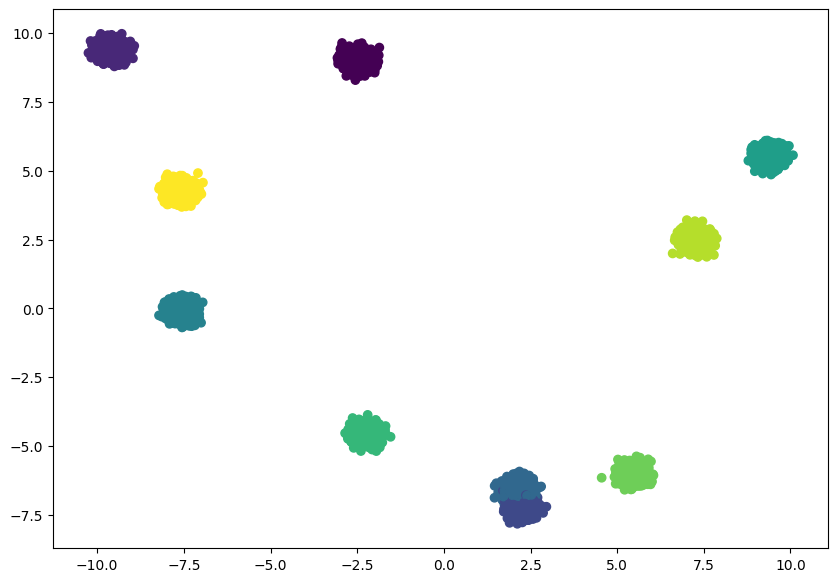

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob)

In [7]:
# Lets build the model
class MultiClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)        

    def forward(self, x : torch.tensor):
        self.l1(x)

model = MultiClass()


Ep: 0 | loss: 0.66657 | tloss: 0.65798 
Ep: 500 | loss: 0.13245 | tloss: 0.13401 
Ep: 1000 | loss: 0.04902 | tloss: 0.05021 
Ep: 1500 | loss: 0.01722 | tloss: 0.01773 
Ep: 2000 | loss: 0.00705 | tloss: 0.00722 
Ep: 2500 | loss: 0.00392 | tloss: 0.00400 
Ep: 3000 | loss: 0.00261 | tloss: 0.00266 
Ep: 3500 | loss: 0.00192 | tloss: 0.00195 
Ep: 4000 | loss: 0.00150 | tloss: 0.00152 
Ep: 4500 | loss: 0.00122 | tloss: 0.00124 


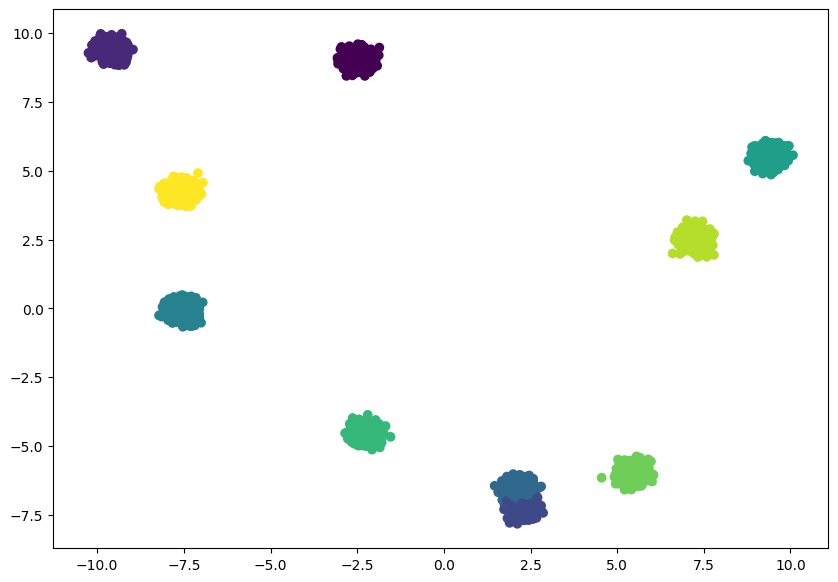

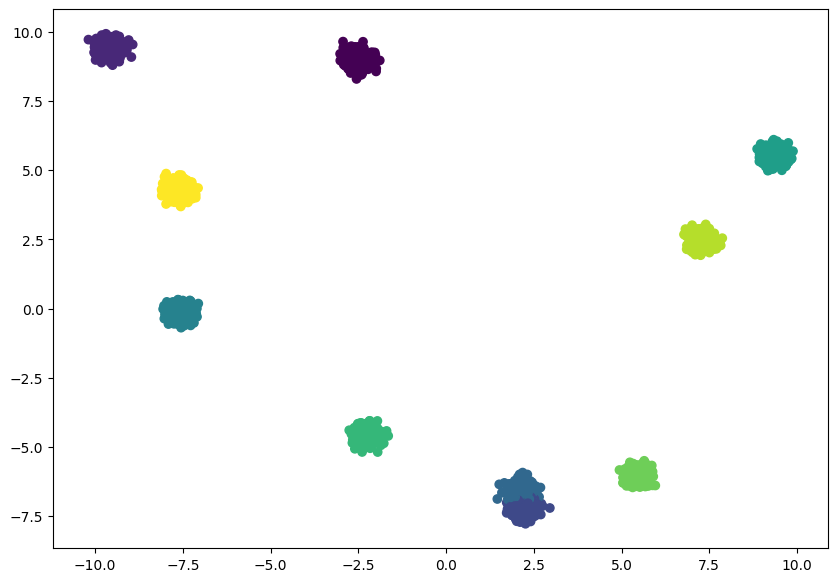

In [8]:
def printClass(X_, y_, n_classes):
    y_train_blob = torch.zeros(len(y_))
    for i in range(len(y_train_blob)):
        for c in range(n_classes):
            if int(y_[i][c].item()) == 1:
                y_train_blob[i] = c

    plt.figure(figsize=(10, 7))
    plt.scatter(X_[:, 0], X_[:, 1], c = y_train_blob)

# Calculate accuracy - out of 100 what percent the model gets right
def accuracy_fn(y_test, preds):
    correct = (y_test == preds).type(torch.float)
    nc = (torch.count_nonzero(correct))
    return  nc.item() / len(y_test) * 100

y = torch.zeros(N_SAMPLES, NUM_CLASSES)
for i in range(len(y_blob)):
    y[i][int(y_blob[i].item())] = 1

# Model with non linearity
model = nn.Sequential(
    nn.Linear(NUM_FEATURES, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.Linear(8, NUM_CLASSES),
)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y, test_size=0.33, random_state=432)
X_train, X_test, y_train, y_test

printClass(X_train, y_train, NUM_CLASSES)

# Training
# Loss for classification
loss_fn = nn.MultiLabelSoftMarginLoss() # This is also the output activation function; so is combining Sigmoid -> BCELoss 
# and is more numerically stable

optimizer = optim.SGD(
    params=model.parameters(),
    lr = 0.03
)
# Training
torch.manual_seed(RANDOM_SEED)
epochs = 5000
for ep in range(epochs):
    model.train()

    # Logits
    y_logits = model(X_train).squeeze()
    # Using sigmoid activation and rounding
    y_pred = torch.round(torch.sigmoid(y_logits))
    # loss and accuracy
    loss = loss_fn(y_logits, # we expect raw logits
                   y_train)

    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # test loss
        test_loss = loss_fn(test_logits, y_test)

    if ep % (epochs / 10) == 0:
        print(f"Ep: {ep} | loss: {loss:.5f} | tloss: {test_loss:.5f} ")

# Lets visualize
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
printClass(X_test, test_pred, NUM_CLASSES)


In [9]:
# hello